Step 0: Imports & Parameters

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

IMAGE_DIR = "./images"  # original images organized in class subfolders


Step 1: Create Train/Test Split Folders

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# On-the-fly augmentations
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.7,1.3)
)


2025-11-13 23:06:42.545719: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-13 23:06:42.792724: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-13 23:06:49.450351: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-13 23:07:01.802888: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Step 2: Create ImageDataGenerators

In [3]:
def extract_features_from_image(image_path):
    """
    Convert image to numpy array and flatten as features
    """
    img = Image.open(image_path).resize((64,64))  # small size for RF
    img_array = np.array(img)
    if len(img_array.shape) == 3:
        img_array = img_array.flatten()  # RGB
    else:
        img_array = img_array.flatten()  # grayscale
    return img_array

all_features = []
all_labels = []

for class_name in os.listdir(IMAGE_DIR):
    class_path = os.path.join(IMAGE_DIR, class_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        # Original
        feats = extract_features_from_image(img_path)
        all_features.append(feats)
        all_labels.append(class_name)
        
        # 6 augmented versions
        img = Image.open(img_path).resize((64,64))
        img_array = np.expand_dims(np.array(img), 0)  # for ImageDataGenerator
        aug_iter = datagen.flow(img_array, batch_size=1)
        for _ in range(6):
            aug_img = next(aug_iter)[0].astype(np.uint8)
            all_features.append(aug_img.flatten())
            all_labels.append(class_name)

print(f"Total samples (original + augmentations): {len(all_features)}")


Total samples (original + augmentations): 84


tep 3: Build the CNN (EfficientNetB0 Transfer Learning)

In [6]:
X = np.array(all_features)
y = np.array(all_labels)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


Training samples: 67
Testing samples: 17


Step 4: Train the Model

In [7]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("Random Forest training complete!")


Random Forest training complete!


Step 5: Evaluate the Model

Random Forest Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

      Caline       1.00      1.00      1.00         4
        Keza       1.00      1.00      1.00         4
       Senga       1.00      1.00      1.00         5
    Theodora       1.00      1.00      1.00         4

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



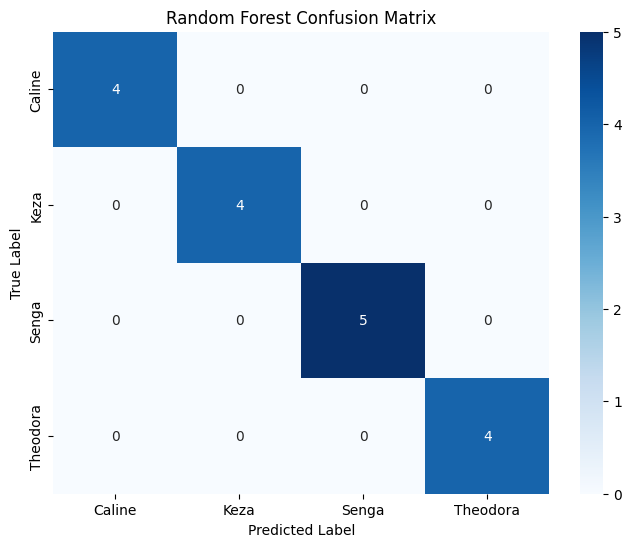

In [8]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy*100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()


In [10]:
import joblib

# --- 6a. Save the trained Random Forest model ---
model_filename = 'image_model.pkl'
joblib.dump(model, model_filename)

# --- 6b. Save the Label Encoder ---
encoder_filename = 'image_label_encoder.pkl'
joblib.dump(le, encoder_filename)

print(f"Random Forest model saved to: {model_filename}")
print(f"Label Encoder saved to: {encoder_filename}")


Random Forest model saved to: image_model.pkl
Label Encoder saved to: image_label_encoder.pkl


In [12]:
def predict_image_class(image_file, threshold=0.5):
    """
    Predict the class of an image using the trained Random Forest model.
    Returns 'unauthorized' if the model is not confident enough.

    Parameters:
        image_file (str): Path to the image file.
        threshold (float): Minimum probability to accept a prediction.

    Returns:
        str: Predicted class or 'unauthorized'.
    """
    try:
        # Load and preprocess image
        img = Image.open(image_file).resize((64, 64))
        img_array = np.array(img)
        features = img_array.flatten().reshape(1, -1)

        # Predict probabilities
        probs = model.predict_proba(features)[0]
        max_prob = np.max(probs)
        predicted_label = le.inverse_transform([np.argmax(probs)])[0]

        if max_prob >= threshold:
            return predicted_label
        else:
            return "unauthorized"

    except Exception as e:
        return f"Error processing the image: {e}"


In [13]:
test_image = '/home/sng/Desktop/Tunel/ALU/Test/data_pro/Theodora_Face_Smiling.jpeg'
predicted_class = predict_image_class(test_image, threshold=0.6)
print(f"Predicted class: {predicted_class}")


Predicted class: Error processing the image: [Errno 2] No such file or directory: '/home/sng/Desktop/Tunel/ALU/Test/data_pro/Theodora_Face_Smiling.jpeg'
